**Instructors**: Prof. Keith Chugg (chugg@usc.edu) & Prof. B. Keith Jenkins (jenkins@sipi.usc.edu)

**Notebook**: Written by PhD student Hassan Hammad from Prof. Chugg's group.

# Multiclass Classifier for MNIST (and Fashion MNIST) Using MLP in PyTorch

In this notebook, we will use PyTorch to train an ANN/MLP for the FMNIST dataset.  There are many variations, but this is a good template to use for PyTorch training of neural networks.

This notebook requires torch to be installed. To install this, use `pip3 install torch torchvision torchaudio`. This will work on Nvidia GPU, as well as on an M1/M2 Apple chip. You also need to install `tqdm` which is a package used to provide training progress results.

In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from utils.torch_full_dataset import FullDataset

# Accessing the Data
First, let's get the data. Torchvision provides many built-in datasets including Fashion MNIST. Fashion MNIST is a dataset of 28x28 images of fashion items.

In [2]:
# All datasets are subclasses of torch.utils.data.Dataset i.e, they have __getitem__ and __len__ methods implemented
from torchvision import datasets, transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),]) # transforms.ToTensor() converts the image to a tensor and transforms.Normalize() normalizes the tensor
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)

In [3]:
testset.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [4]:
image, label = trainset[0] 
print(image.shape) # torch.Size([1, 28, 28])
print(label) 

torch.Size([1, 28, 28])
9


Fashion MNIST dataset comes as train and test sets, of sizes 60,000 and 10,000 respectively.
If we want to use a validation set, we need to create it manually

In [5]:
trainset, valset = torch.utils.data.random_split(trainset, [50000, 10000])
# Final sizes are 50000, 10000, 10000
print(f'Train set size: {len(trainset)}, Validation set size: {len(valset)}, Test set size: {len(testset)}')

# use this dataloader to load the entier daatset into RAM
trainset = FullDataset(trainset)
valset = FullDataset(valset)

Train set size: 50000, Validation set size: 10000, Test set size: 10000


In PyTorch, data is loaded using data loaders, which are iterators over the dataset.
Data Loaders need a batch size, which is the size of the data batch extracted in each iteration.
We will create a dataloader for each data split.

In [6]:
batchsize = 32
# Shuffle the data at the start of each epoch (only useful for training set)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batchsize, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize, shuffle=False)

# ANN/MLP Model Definition
Create a 2-layer neural network. In Pytorch, `nn.Module` is the base class for all neural network modules in PyTorch.
Your models should also subclass this class

In [7]:
# Parameters for the model
n_pixels = 28 * 28
n_classes = 10
n_hidden = 48

# Define the model
class MLP(nn.Module):
    def __init__(self, n_pixels, n_classes, n_hidden): # Define layers in the constructor
        super().__init__()
        self.fc1 = nn.Linear(n_pixels, n_hidden)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden, n_classes)
        
    def forward(self, x): # Define forward pass in the forward method
        x = x.view(x.shape[0], -1)  #flatten into a 784 length tensor
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x # note: no softmax, as this is included in the loss function in PyTorch
    
model = MLP(n_pixels, n_classes, n_hidden)
print(model)

MLP(
  (fc1): Linear(in_features=784, out_features=48, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=48, out_features=10, bias=True)
)


For multi-class classification, we use the cross entropy loss function. In pytorch, the input to `nn.CrossEntropyLoss` should be logits not probabilities. The loss function combines softmax with loss calculation for numerical stability. For the optimizer algorithm, we will use Adam, a very popular optimizer.

In [8]:
lr = 1e-2   ## the learning rate in TF is part of the optimizer.  Default is 1e-2
reg_val = 1e-4
criterion = nn.CrossEntropyLoss() # includes softmax (for numerical stability)
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=reg_val)

In [9]:
# set the device to use and move model to device
# if torch.cuda.is_available():
#     device = torch.device("cuda:0")
# elif torch.torch.backends.mps.is_available():
#     device = torch.device("mps") # MPS acceleration is available on MacOS 12.3+
# else:
#     device = torch.device("cpu")

# for this small model, the CPU is faster than the GPU.
device = torch.device("cpu")
print(f'Using device: {device}')
model.to(device) # Move model to device

Using device: cpu


MLP(
  (fc1): Linear(in_features=784, out_features=48, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=48, out_features=10, bias=True)
)

# Training the Model
Unlike Keras, in Pytorch we need to explicitly write the training functions. This includes iterating over data batches, forward and backward passes, loss caluclation and updating the weights.
We will write two functions. One for trianing loops (to update the weights of the model) and one for validation loop (to evaluate performance).

In [10]:
# Define function to call for each training epoch (one complete pass over the training set)
def train(model, trainloader, criterion, optimizer, device):
    model.train() # set model to training mode
    running_loss = 0; running_acc = 0
    with tqdm(total=len(trainloader), desc=f"Train", unit="batch") as pbar:
        for n_batch, (images, labels) in enumerate(trainloader): # Iterate over batches
            images, labels = images.to(device), labels.to(device) # Move batch to device
            optimizer.zero_grad()
            output = model(images) # Forward pass
            loss = criterion(output, labels) # Compute loss
            loss.backward() # Backward pass
            optimizer.step() # Update weights
            running_loss += loss.item()
            running_acc += (output.argmax(1) == labels).float().mean().item()
            pbar.set_postfix({'loss': loss.item(), 'acc': 100. * running_acc / (n_batch+1)})
            pbar.update() # Update progress bar
    return running_loss / len(trainloader), running_acc / len(trainloader) # return loss and accuracy for this epoch

In [11]:
# Define function to call for each validation epoch (one complete pass over the validation set)
def validate(model, valloader, criterion, device):
    model.eval() # set model to evaluation mode (e.g. turn off dropout, batchnorm, etc.)
    running_loss = 0; running_acc = 0
    with torch.no_grad(): # no need to compute gradients for validation
        with tqdm(total=len(valloader), desc=f"Eval", unit="batch") as pbar:
            for n_batch, (images, labels) in enumerate(valloader): # Iterate over batches
                images, labels = images.to(device), labels.to(device) # Move batch to device
                output = model(images) # Forward pass
                loss = criterion(output, labels) # Compute loss
                running_loss += loss.item() 
                running_acc += (output.argmax(1) == labels).float().mean().item()
                pbar.set_postfix({'loss': loss.item(), 'acc': 100. * running_acc / (n_batch+1)})
                pbar.update() # Update progress bar
    return running_loss / len(valloader), running_acc / len(valloader)  # return loss and accuracy for this epoch

Finally we loop over the number of epochs. In each epoch we loop once over the training dataset and update the model weights. Then we loop once over the validation dataset and calculate validation loss and accuracy. We will use tqdm to display the progress bar. We also save the model that acheived the best validation accuracy across all epochs.

 Note: the training loss/acc displayed are running averages during training while the validation loss/acc are computed after training epoch is finished. This is why val loss might be lower than training loss in the first few epochs. To compare train vs val peformance on the same model, we can recompute training loss/acc after epoch is finished. This takes extra time so we usually ignore it

In [12]:
# Run training and validation loop
# Save the best model based on validation accuracy
n_epochs = 30
best_acc = -1
train_loss_history = []; train_acc_history = []
val_loss_history = []; val_acc_history = []
for epoch in range(n_epochs): # Iterate over epochs
    print(f"Epoch {epoch+1} of {n_epochs}")
    train_loss, train_acc  = train(model, trainloader, criterion, optimizer, device) # Train
    val_loss, val_acc = validate(model, valloader, criterion, device) # Validate
    train_loss_history.append(train_loss); train_acc_history.append(train_acc)
    val_loss_history.append(val_loss); val_acc_history.append(val_acc)
    if val_acc > best_acc: # Save best model
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model.pt") # saving model parameters ("state_dict") saves memory and is faster than saving the entire model

Epoch 1 of 30


Eval: 100%|██████████| 313/313 [00:00<00:00, 1446.86batch/s, loss=0.25, acc=80.7] 


Epoch 2 of 30


Eval: 100%|██████████| 313/313 [00:00<00:00, 643.71batch/s, loss=0.16, acc=84.3] 


Epoch 3 of 30


Eval: 100%|██████████| 313/313 [00:00<00:00, 1009.79batch/s, loss=0.155, acc=84.4]


Epoch 4 of 30


Eval: 100%|██████████| 313/313 [00:00<00:00, 1097.37batch/s, loss=0.159, acc=85.2]


Epoch 5 of 30


Eval: 100%|██████████| 313/313 [00:00<00:00, 1176.67batch/s, loss=0.154, acc=85.5] 


Epoch 6 of 30


Eval: 100%|██████████| 313/313 [00:00<00:00, 1249.33batch/s, loss=0.117, acc=86.5] 


Epoch 7 of 30


Eval: 100%|██████████| 313/313 [00:00<00:00, 1202.31batch/s, loss=0.148, acc=86]  


Epoch 8 of 30


Eval: 100%|██████████| 313/313 [00:00<00:00, 1541.47batch/s, loss=0.098, acc=87]   


Epoch 9 of 30


Eval: 100%|██████████| 313/313 [00:00<00:00, 1140.47batch/s, loss=0.145, acc=86.1] 


Epoch 10 of 30


Eval: 100%|██████████| 313/313 [00:00<00:00, 1274.28batch/s, loss=0.0966, acc=87]  


Epoch 11 of 30


Eval: 100%|██████████| 313/313 [00:00<00:00, 1222.80batch/s, loss=0.146, acc=86.9]


Epoch 12 of 30


Eval: 100%|██████████| 313/313 [00:00<00:00, 1149.31batch/s, loss=0.094, acc=86.9] 


Epoch 13 of 30


Eval: 100%|██████████| 313/313 [00:00<00:00, 1306.66batch/s, loss=0.119, acc=87.1] 


Epoch 14 of 30


Eval: 100%|██████████| 313/313 [00:00<00:00, 1243.75batch/s, loss=0.129, acc=87.2] 


Epoch 15 of 30


Eval: 100%|██████████| 313/313 [00:00<00:00, 1270.40batch/s, loss=0.123, acc=87.5] 


Epoch 16 of 30


Eval: 100%|██████████| 313/313 [00:00<00:00, 1158.14batch/s, loss=0.113, acc=87.3] 


Epoch 17 of 30


Eval: 100%|██████████| 313/313 [00:00<00:00, 1237.16batch/s, loss=0.0971, acc=87.9]


Epoch 18 of 30


Eval: 100%|██████████| 313/313 [00:00<00:00, 1228.25batch/s, loss=0.129, acc=87.9]


Epoch 19 of 30


Eval: 100%|██████████| 313/313 [00:00<00:00, 1207.66batch/s, loss=0.0739, acc=87.7]


Epoch 20 of 30


Eval: 100%|██████████| 313/313 [00:00<00:00, 1253.35batch/s, loss=0.173, acc=87.2] 


Epoch 21 of 30


Eval: 100%|██████████| 313/313 [00:00<00:00, 1069.57batch/s, loss=0.0843, acc=87.9]


Epoch 22 of 30


Eval: 100%|██████████| 313/313 [00:00<00:00, 1135.38batch/s, loss=0.112, acc=87.6]


Epoch 23 of 30


Eval: 100%|██████████| 313/313 [00:00<00:00, 1292.60batch/s, loss=0.0778, acc=87.6]


Epoch 24 of 30


Eval: 100%|██████████| 313/313 [00:00<00:00, 1228.58batch/s, loss=0.0915, acc=87.6]


Epoch 25 of 30


Eval: 100%|██████████| 313/313 [00:00<00:00, 1169.25batch/s, loss=0.106, acc=88]   


Epoch 26 of 30


Eval: 100%|██████████| 313/313 [00:00<00:00, 1035.76batch/s, loss=0.133, acc=87.7] 


Epoch 27 of 30


Eval: 100%|██████████| 313/313 [00:00<00:00, 1226.04batch/s, loss=0.0801, acc=88.2]


Epoch 28 of 30


Eval: 100%|██████████| 313/313 [00:00<00:00, 1198.12batch/s, loss=0.0957, acc=87.9]


Epoch 29 of 30


Eval: 100%|██████████| 313/313 [00:00<00:00, 1203.11batch/s, loss=0.0698, acc=88]  


Epoch 30 of 30


Eval: 100%|██████████| 313/313 [00:00<00:00, 1233.93batch/s, loss=0.0835, acc=88.2]


# Visualizing the Training/Validation (Learning Curves)

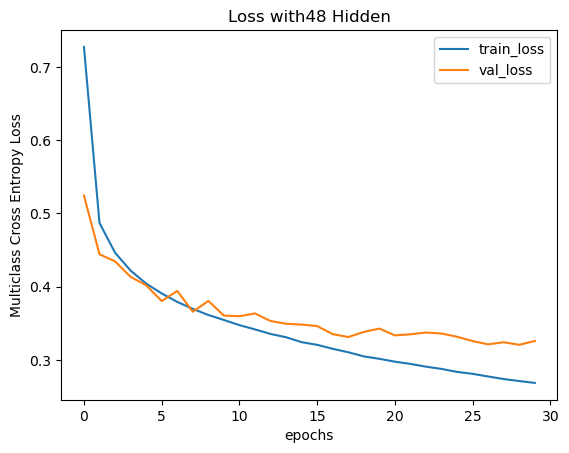

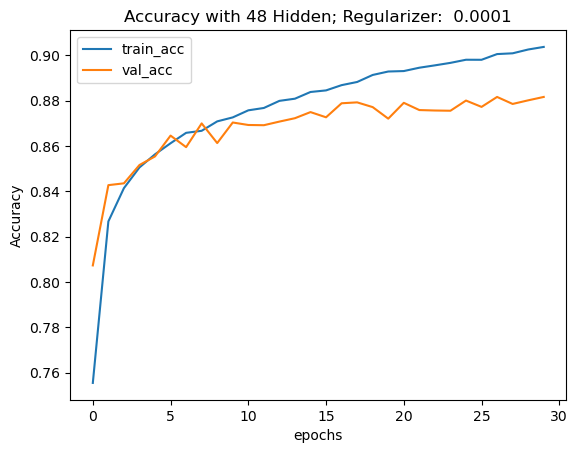

In [13]:
epochs = torch.arange(n_epochs)

# plot training and validation loss
plt.figure()
plt.plot(epochs, train_loss_history, label='train_loss')
plt.plot(epochs, val_loss_history, label='val_loss')
plt.xlabel('epochs')
plt.ylabel('Multiclass Cross Entropy Loss')
plt.title(f'Loss with{n_hidden} Hidden')
plt.legend()

# plot training and validation accuracy
plt.figure()
plt.plot(epochs, train_acc_history, label='train_acc')
plt.plot(epochs, val_acc_history, label='val_acc')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title(f'Accuracy with {n_hidden} Hidden; Regularizer: {reg_val : 3.2g}')
plt.legend()


# Evaluating on the Test Data

In [14]:
# Load the best model and evaluate on test set
model.load_state_dict(torch.load("best_model.pt"))
test_loss, test_acc = validate(model, testloader, criterion, device)
print(f"Test accuracy: {test_acc:.4f}")

Eval: 100%|██████████| 313/313 [00:00<00:00, 404.08batch/s, loss=0.115, acc=87.1] 

Test accuracy: 0.8710


Perform inference on a single image form the test set.  In PyTorch, when doing inference, the model should be put in `.eval()` mode and you should use the `with torch.no_grad()` statement.  For more complex networks, the `.eval()` configures the layers to be in inference mode (e.g., a dropout layer needs to be configured for training or inference) and the `with torch.no_grad()` ensures that the gradient is not be tracked.  

Test Image Number: 8495, Predicted class: T-shirt/top


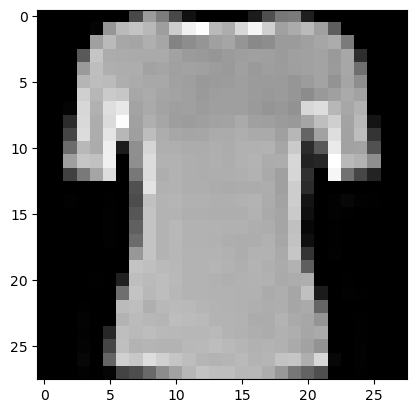

In [15]:
model.eval() # set model to evaluation mode 
img = np.random.randint(10000)
with torch.no_grad():
    image, label = testset[img] # get first image and label from test set
    image = image.to(device)  # move image to device
    output = model(image) # forward pass
pred = output.argmax(1) # get predicted class
print(f"Test Image Number: {img}, Predicted class: {testset.classes[pred.item()]}")
# plot image 
plt.figure()
plt.imshow(image.cpu().numpy().squeeze(), cmap='gray')
